In [1]:
import mlflow
import mlflow.keras
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

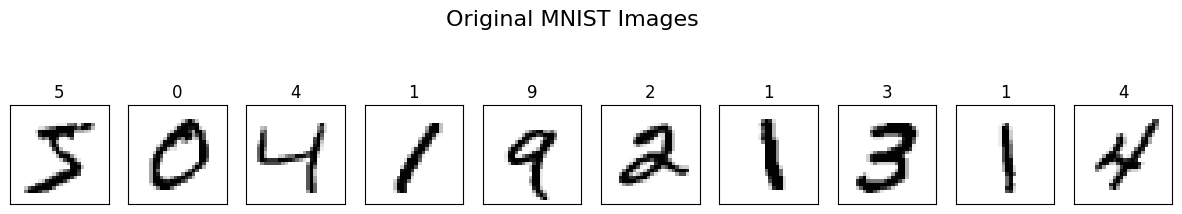

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

n_images = 10
plt.figure(figsize=(15, 3))

for i in range(n_images):
    ax = plt.subplot(1, n_images, i + 1)

    # Get the image and remove the channel dimension (squeeze)
    image_to_show = X_train_full[i].squeeze()

    # Display the image. 'binary' cmap is best for black/white images.
    plt.imshow(image_to_show, cmap='binary')

    # Display the corresponding label
    plt.title(f"{y_train_full[i]}")

    # # Remove the axis ticks and labels for cleaner display
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("Original MNIST Images", fontsize=16)
plt.show()

# Data Loading and Preprocessing
We load the MNIST dataset, which consists of handwritten digits.

**`tf.keras.datasets.mnist.load_data()`** fetches the dataset, providing training and test images along with their labels.

We add a channel dimension to the images (X_train_full[..., None]) because Conv2D layers expect input in the format (batch_size, height, width, channels).

We use **`train_test_split`** to further divide the training data into a training set and a validation set. The validation set is crucial for monitoring model performance during training and detecting overfitting.

**`ImageDataGenerator`** is used to rescale the pixel values from [0, 255] to [0, 1]. This normalization helps the neural network learn more effectively. 

We create separate generators for training, validation, and testing to ensure consistent preprocessing.

In [3]:
X_train_full = X_train_full[..., None]
X_test = X_test[..., None]

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size= 0.1,
    random_state=42
)

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow(X_train, y_train, batch_size=128)
val_gen = val_datagen.flow(X_val, y_val, batch_size=128)
test_gen = test_datagen.flow(X_test, y_test, batch_size=128, shuffle=False)

**`params` Dictionary**: Defines hyper-parameters for our model, making it easy to log them with MLflow.

In [4]:
#setting a parameter dictionary for mlflow
params = {

    #for architecture of neural network
    "batch_size": 128,
    "epochs" : 6,
    "conv_filters": 32,
    "dense_units": 64,
    "hidden_activation": "relu",
    "output_activation": "softmax",

    # for compile
    "optimizer": "adam",
    "loss": "sparse_categorical_crossentropy"
}

In [5]:
model = models.Sequential([
    layers.Conv2D(params["conv_filters"], (3,3), 
                  activation=params["hidden_activation"], 
                  input_shape=(28,28,1)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(params["dense_units"], 
                 activation= params["hidden_activation"]),
    layers.Dense(10, 
                 activation=params["output_activation"])
])

model.compile(
    optimizer = params["optimizer"],
    loss = params["loss"],
    metrics=['accuracy']
)

model.summary()

C:\Users\000837194\Documents\ml_flow_project\myvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         346,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 347,146 (1.32 MB)

 Trainable params: 347,146 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

### **MLflow Experiment Tracking and Model Training**

1.  **`mlflow.set_experiment("MNIST_CNN_example")`**: Organizes runs under a specific experiment name, making it easier to compare related runs.

2.  **`run_notes`**: A multiline string to add detailed descriptions and observations for each MLflow run, enhancing traceability.

3.  **`with mlflow.start_run(...) as run:`**: This context manager creates an MLflow run. All subsequent MLflow logging within this block will be associated with this specific run.
    *   **`mlflow.log_params(params)`**: Logs all the hyperparameters defined in the `params` dictionary.
    *   **`model.fit(...)`**: Trains the model using the prepared data generators for a specified number of epochs. The `history` object stores training metrics.
    *   **`model.evaluate(...)`**: Evaluates the trained model on the unseen test set to get final performance metrics.
    *   **`mlflow.log_metric(...)`**: Logs individual performance metrics (test accuracy, loss, final train/validation accuracy) to the MLflow run.
    *   **`mlflow.keras.log_model(...)`**: Logs the entire trained Keras model as an artifact. `artifact_path='model'` specifies where the model will be stored within the run's artifact URI, and `registered_model_name='MNIST_CNN'` registers the model in the MLflow Model Registry, allowing for versioning and easy deployment.
    *   **`run_id = run.info.run_id`**: Captures the unique ID of the current MLflow run, which is useful for retrieving artifacts later.

In [6]:
mlflow.set_experiment("MNIST_CNN_example")

run_notes = """
Run 2: Base CNN Architecture Test
Establish a baseline performance with a simple 3-layer CNN.
changed the optimizer to Adam
"""

with mlflow.start_run(description=run_notes) as run:

    mlflow.set_tag("model_type", "CNN")
    mlflow.set_tag("optimizer", params["optimizer"])
    mlflow.set_tag("purpose", "baseline")
    
    mlflow.log_params(params)

    history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = params['epochs']
    )

    test_loss, test_accuracy = model.evaluate(test_gen)

    y_pred = model.predict(test_gen)
    y_pred_classes = y_pred.argmax(axis=1)
    
    # Get true labels - depends on your y_test format
    if len(y_test.shape) == 1:  
        y_true = y_test
    else: 
        y_true = y_test.argmax(axis=1)

    # saving metrics 
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("final_train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("final_val_accuracy", history.history['val_accuracy'][-1])

    model_info = mlflow.keras.log_model(
        model,
        artifact_path="model",
        registered_model_name="MNIST_CNN"
    )

    run_id = run.info.run_id

print(f"Run ID: {run_id}")
print(f"Test accuracy: {test_accuracy:.4f}")

C:\Users\000837194\Documents\ml_flow_project\myvenv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/11/18 16:31:36 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - qui

Epoch 1/6
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9198 - loss: 0.2804 - val_accuracy: 0.9685 - val_loss: 0.1096
Epoch 2/6
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9740 - loss: 0.0882 - val_accuracy: 0.9803 - val_loss: 0.0745
Epoch 3/6
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9823 - loss: 0.0594 - val_accuracy: 0.9815 - val_loss: 0.0653
Epoch 4/6
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9863 - loss: 0.0454 - val_accuracy: 0.9785 - val_loss: 0.0692
Epoch 5/6
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9894 - loss: 0.0357 - val_accuracy: 0.9812 - val_loss: 0.0592
Epoch 6/6
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9910 - loss: 0.0292 - val_accuracy: 0.9852 - val_loss: 0.0525
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9850 - loss: 0.0467
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


2025/11/18 16:32:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/18 16:32:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/18 16:32:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
C:\Users\000837194\Documents\ml_flow_project\myvenv\Lib\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning: Filesystem model registry backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri)
Registered model 'MNIST_CNN' already exists. Creating a new version of this model...


Run ID: f2d2b75fade84a459794c1f0c8eae780
Test accuracy: 0.9850


Created version '12' of model 'MNIST_CNN'.


### **Visualizing and Logging Training History**

This cell visualizes the model's training and validation accuracy and loss over epochs, providing insights into its learning process and potential overfitting.

1.  **Extracting History**: We retrieve `accuracy`, `val_accuracy`, `loss`, and `val_loss` from the `history` object returned by `model.fit()`.

2.  **Plotting**: `matplotlib.pyplot` is used to create two subplots: one for accuracy and one for loss. Both plots show how the training and validation metrics changed over each epoch.

3.  **Saving the Plot**: `plt.savefig("training_history.png")` saves the generated plot as an image file.

4.  **Logging Artifact**: `with mlflow.start_run(run_id=run_id): mlflow.log_artifact("training_history.png")` logs the saved plot image as an artifact to the *same MLflow run* that trained the model. This ensures that the visual representation of the training history is directly associated with the model and its metrics, making it easy to review the experiment's performance visually.

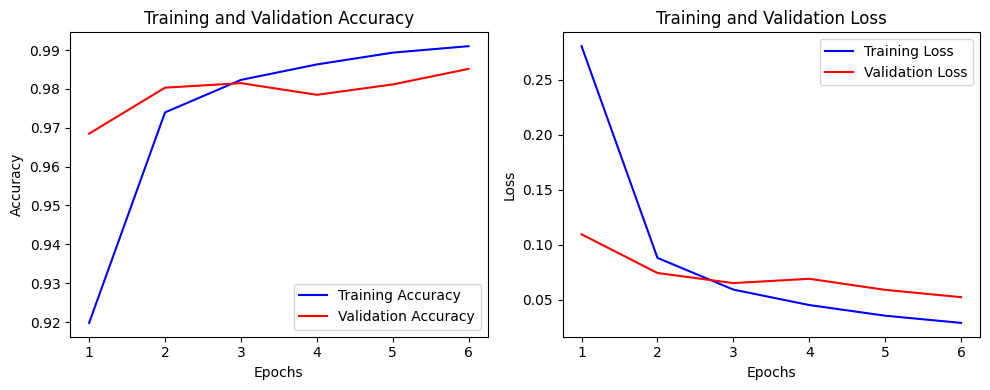

In [7]:
# Extract values from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 📈 Plot accuracy
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 📉 Plot loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("training_history.png")

with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact("training_history.png")
    
plt.show()

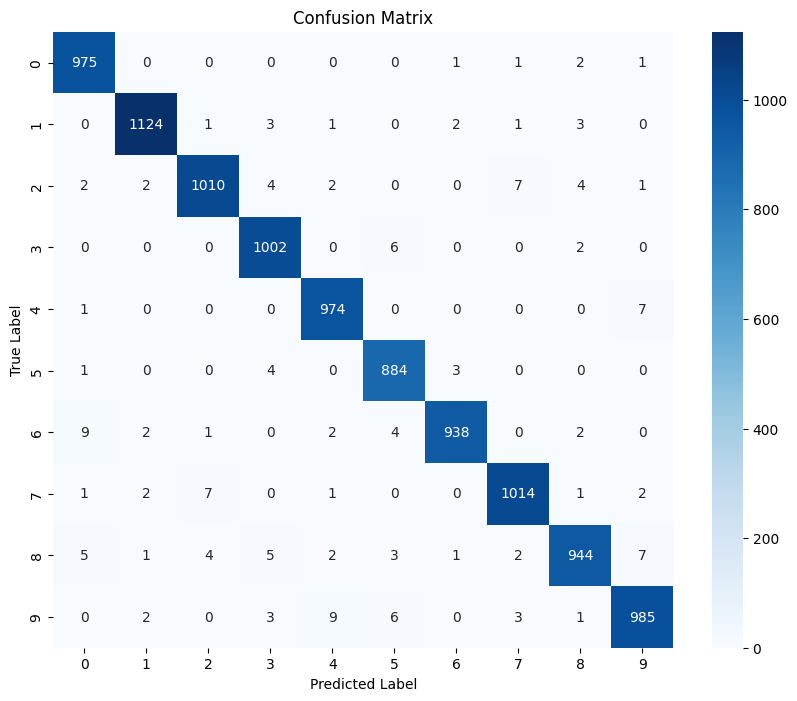

In [8]:
# Create and save confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("confusion_matrix.png")

with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact("confusion_matrix.png")

### 

**Loading Model and Making Predictions**

This final cell demonstrates how to load a model previously logged with MLflow and use it for inference.

1.  **`mlflow.keras.load_model(f"runs:/{run_id}/model")`**: Loads the Keras model that was saved during the MLflow run. The `f"runs:/{run_id}/model"` URI specifies that we want to load the model artifact from a particular run ID (which we captured earlier).

2.  **Preparing Sample Images**: We take the first 5 images from the test set (`X_test`) and rescale them (as the model was trained on rescaled images).

3.  **`loaded_model.predict(sample_images)`**: Uses the loaded model to make predictions on the prepared sample images. The output is a probability distribution over the 10 classes for each image.

4.  **`np.argmax(predictions, axis=1)`**: Converts the probability distributions into class labels by selecting the index with the highest probability for each prediction.

5.  **Printing Results**: Displays the predicted classes and compares them with the actual labels of the sample images, verifying the model's functionality.

In [9]:
# Loading the model from MLflow
loaded_model = mlflow.keras.load_model(f"runs:/{run_id}/model")

# Make predictions
sample_images = X_test[:5] / 255.0
predictions = loaded_model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

print("Predicted classes:", predicted_classes)
print("Actual classes:", y_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted classes: [7 2 1 0 4]
Actual classes: [7 2 1 0 4]
